In [10]:
import numpy as np
import os
from torch.utils.data import Dataset
import torch
import torch.nn as nn 
from torch.nn.utils import rnn

In [11]:
# dataset that loads data like np.load("sleep/SC4412-0.npy")
class SleepDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.files = [x.split('.')[0] for x in os.listdir(root_dir) if 'labels' not in x]
        
        #0 is reserved for padding... or blank?
        self.sleep_stage_to_idx = {'Sleep stage W': 7, 'Sleep stage 1': 1, 'Sleep stage 2': 2, 'Sleep stage 3': 3, 'Sleep stage 4': 4, 'Sleep stage R': 5, 'Sleep stage ?': 6, 'Movement time': 8}
        self.idx_to_sleep_stage = {7: 'Sleep stage W', 1: 'Sleep stage 1', 2: 'Sleep stage 2', 3: 'Sleep stage 3', 4: 'Sleep stage 4', 5: 'Sleep stage R', 6: 'Sleep stage ?', 8:'Movement time'}
        
        self.num_classes = len(self.sleep_stage_to_idx) + 1

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        
        sample = os.path.join(self.root_dir, self.files[idx])
        X = np.load(sample + ".npy")
        y = np.load(sample + "-labels.npy", allow_pickle=True)
        # turn y into idxs
        y = np.array([self.sleep_stage_to_idx[x] for x in y])

        # turn into torch tensors
        X = torch.from_numpy(X).float()
        y = torch.from_numpy(y)
        return X, y

In [12]:
dataset = SleepDataset('sleep')
train_set_pct = 0.8
train, validation = torch.utils.data.random_split(dataset, [int(len(dataset)*train_set_pct), len(dataset) - int(len(dataset)*train_set_pct)])

In [13]:
# collate with padded sequences
def collate_fn(batch):
    X, y = zip(*batch)

    X = torch.concatenate([x.unsqueeze(0) for x in X])
    
    y = rnn.pack_sequence(y, enforce_sorted=False)
    y, y_lens = rnn.pad_packed_sequence(y, batch_first=True)
    
    # sort both y and X according to y lens
    y_lens, sort_idx = y_lens.sort(descending=True)

    return X[sort_idx], y[sort_idx], y_lens

batch_size=32
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
X, y, y_lens= next(iter(train_loader))

In [38]:
class CTCNetwork(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_size=num_features, hidden_size=num_classes, num_layers=1, 
                            batch_first=True, bidirectional=True)
        self.output = nn.Linear(2*num_classes, num_classes)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        x, _ = self.lstm(x)
        out = self.output(x.data)
        out = self.softmax(out)
        return out
    
model = CTCNetwork(num_features=X.shape[-1], num_classes=dataset.num_classes)
emissions = model(X)
print(emissions.shape)
    

torch.Size([32, 60, 9])


In [39]:
from tqdm import tqdm
epochs=1000
model = CTCNetwork(num_features=X.shape[-1], num_classes=dataset.num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=10**(-4), momentum=0.9)
model.train()
ctc_loss = nn.CTCLoss()

num_steps = len(train_loader)*epochs
epoch = 1
with tqdm(range(num_steps)) as pbar:
    for step in pbar:
        X, y, y_lens = next(iter(train_loader))
        optimizer.zero_grad()
        emissions = model(X)
        input_lengths = torch.full(size=(X.shape[0],), fill_value=X.shape[1], dtype=torch.long)
        loss = ctc_loss(emissions.permute(1, 0, 2), y, input_lengths, y_lens)
        loss.backward()
        optimizer.step()

        # Report
        if step % 20 ==0 :
            loss = loss.detach().cpu()
            pbar.set_description(f"epoch={epoch}, step={step}, loss={loss:.1f}")

        if (step+1) % len(train_loader) == 0:
            epoch += 1

epoch=1000, step=136980, loss=13.6: 100%|██████████| 137000/137000 [24:31<00:00, 93.08it/s] 


In [40]:
np.exp(emissions[0].detach().cpu().numpy()).shape

(60, 9)

[]

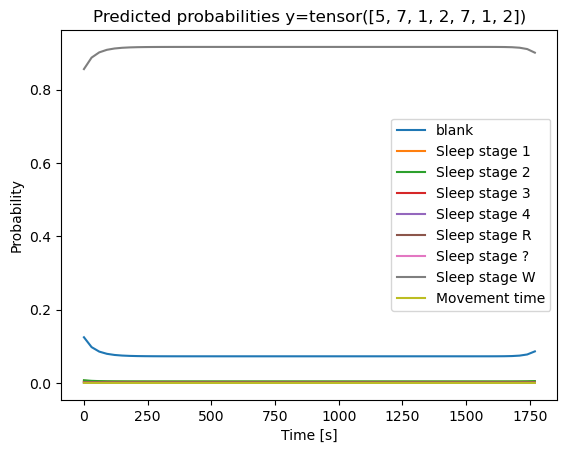

In [41]:
import matplotlib.pyplot as plt
id = 6
probs = np.exp(emissions[id].detach().numpy())
for i in range(probs.shape[1]):
    x = np.arange(probs.shape[0])*30
    plt.plot(x, probs[:, i], label=dataset.idx_to_sleep_stage[i] if i != 0 else 'blank')
plt.title(f'Predicted probabilities y={y[id][:y_lens[id]]}')
plt.ylabel('Probability')
plt.xlabel('Time [s]')
plt.legend()
plt.plot()